In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import lsst.daf.persistence
DATA_DIR_DITHERED = "/global/cscratch1/sd/descdm/DC1/DC1-imsim-dithered/"
DATA_DIR_UNDITHERED = "/global/cscratch1/sd/descdm/DC1/DC1-imsim-undithered/"

I call the butler to get the data

In [4]:
butler = lsst.daf.persistence.Butler(DATA_DIR_DITHERED)

In [9]:
print butler.getKeys("deepCoadd_ref")
print butler.getKeys("deepCoadd_calexp")
print butler.getKeys("deepCoadd_meas")

{'patch': <type 'str'>, 'tract': <type 'int'>}
{'filter': <type 'str'>, 'patch': <type 'str'>, 'tract': <type 'int'>}
{'filter': <type 'str'>, 'patch': <type 'str'>, 'tract': <type 'int'>}


In [7]:
exposure = butler.get("deepCoadd_calexp", filter='r', patch='10,10', tract=0, immediate=True)

In [11]:
catalog = butler.get("deepCoadd_ref", patch='10,10', tract=0, immediate=True)

In [12]:
catalog2 = butler.get("deepCoadd_meas", patch='10,10', tract=0, immediate=True, filter='r')

In [13]:
print len(catalog)

79076


In [14]:
print len(catalog2)

79076


In [22]:
catalog.schema

Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
    (Field['Flag'](name="flags_negative", doc="set if source was detected as significantly negative"), Key['Flag'](offset=32, bit=0)),
    (Field['Flag'](name="merge_footprint_i", doc="Detection footprint overlapped with a detection from filter i"), Key['Flag'](offset=32, bit=1)),
    (Field['Flag'](name="merge_footprint_r", doc="Detection footprint overlapped with a detection from filter r"), Key['Flag'](offset=32, bit=2)),
    (Field['Flag'](name="merge_footprint_z", doc="Detection footprint overlapped with a detection from filter z"), Key['Flag'](offset=32, bit=3)),
    (Field['Flag'](name="merge_footpri

In [24]:
calib = exposure.getCalib()
calib.setThrowOnNegativeFlux(False)  # don't raise an exception when we encounter a negative or NaN flux
psfMag, psfMagErr = calib.getMagnitude(catalog.getPsfFlux(), catalog.getPsfFluxErr())

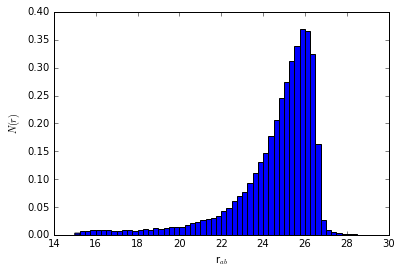

In [46]:
plt.hist(psfMag,range=(15,30),bins=60,normed=True)
plt.xlabel(r'r$_{ab}$')
plt.ylabel(r'$N(r)$')

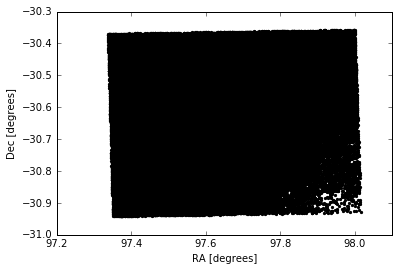

In [44]:
plt.scatter(catalog.get("coord_ra")*180/np.pi,catalog.get("coord_dec")*180/np.pi,marker='.',color='k')
plt.xlabel('RA [degrees]')
plt.ylabel('Dec [degrees]')